<a href="https://colab.research.google.com/github/ebalderasr/ysi-processor/blob/main/process_ysi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Procesamiento de datos YSI

Este notebook procesa archivos CSV crudos exportados del analizador bioquímico **YSI** y genera:

| Archivo generado | Contenido |
|------------------|-----------|
| `ysi_summary.csv` | Agrupación estadística por pozo y metabolito (media, std, CV, outliers) |
| `ysi_summary_wide.csv` | Formato horizontal: una fila por pozo, columnas por metabolito |
| *gráficas de STD* | Visualización de variación técnica por corrida |

Se usa para análisis de cultivos celulares CHO, producción recombinante, seguimiento metabólico, etc.


## ▶ Cómo usar este notebook

1. **Ejecuta la primera celda** y selecciona un archivo CSV crudo del YSI  
   → El archivo debe ser exactamente como lo exporta el instrumento.

2. **Ejecuta las celdas en orden**, sin modificar rutas.

3. **Revisa la tabla de resumen (`summary`)**
   - Incluye media, desviación estándar, CV, número de réplicas y outliers.

4. **Revisa y descarga `ysi_summary_wide.csv`**
   - Útil para cinética y alimentación.

5. **Ejecuta las celdas de graficado**
   - Permite identificar pozos con variabilidad alta entre réplicas.


**Imports + Upload**

In [8]:
# @title
import pandas as pd
import numpy as np
from google.colab import files
import io

print("📂 Sube el archivo RAW exportado del YSI (CSV).")
uploaded = files.upload()

# Detectar nombre automáticamente
filename = list(uploaded.keys())[0]
df_raw = pd.read_csv(io.BytesIO(uploaded[filename]))

print("\n✔ Archivo cargado correctamente:\n")
df_raw.head()


📂 Sube el archivo RAW exportado del YSI (CSV).


Saving Data_test.csv to Data_test (1).csv

✔ Archivo cargado correctamente:



,PlateSequenceName,BatchName,LocalCompletionTime,CompletionState,WellId,ChemistryId,ProbeId,Concentration,Units,Endpoint,...,InitialBaseline,Plateau,FinalBaseline,NetPlateau,NetPlateauTempAdj,CrossNetPlateau,CrossNetPlateauTempAdj,PlateauSlope,Temperature,Errors
0,20251114-T0-T4,TestBatch-1,18/11/2025 12:40:52 p.m.,Complete,R24_A01,Glucose,Probe1A,6.280666,g/L,00:00:30,...,0.216883,8.625994,0.457235,8.409111,8.412536,NaN,NaN,0.203174,25.672058,NaN
1,20251114-T0-T4,TestBatch-1,18/11/2025 12:40:52 p.m.,Complete,R24_A01,Lactate,Probe1B,0.087222,g/L,00:00:30,...,1.745593,2.343027,1.680132,0.597434,0.597677,NaN,NaN,-0.089566,25.672058,NaN
2,20251114-T0-T4,TestBatch-1,18/11/2025 12:41:42 p.m.,Complete,R24_A01,Glutamine,Probe2A,5.681662,mmol/L,00:00:50,...,0.729645,4.572505,0.808810,3.842860,3.876541,0.76717,0.768506,-0.399595,25.264404,NaN
3,20251114-T0-T4,TestBatch-1,18/11/2025 12:41:42 p.m.,Complete,R24_A01,Glutamate,Probe2B,1.814491,mmol/L,00:00:50,...,1.001786,1.768956,1.002757,0.767170,0.768506,NaN,NaN,-0.526240,25.264404,NaN
4,20251114-T0-T4,TestBatch-1,18/11/2025 12:43:30 p.m.,Complete,R24_A02,Glucose,Probe1A,6.280143,g/L,00:00:30,...,0.405913,8.832634,0.449033,8.426720,8.411836,NaN,NaN,0.020313,25.734161,NaN


**Procesar replicas → Summary**

In [10]:
# @title
# Función outliers
def detect_outliers_zscore(values, threshold=2.0):
    if len(values) < 3:
        return [False] * len(values)
    mean = np.mean(values)
    std = np.std(values)
    if std == 0:
        return [False] * len(values)
    return [abs((v - mean) / std) > threshold for v in values]


# Procesamiento
df = df_raw.copy()
df.columns = df.columns.str.strip()
df["Conc_clean"] = pd.to_numeric(df["Concentration"], errors="coerce")
df["is_outlier"] = False


# 🔥 CORRECCIÓN: agrupar por PlateSequenceName también
for (plate, well, chem), group in df.groupby(["PlateSequenceName", "WellId", "ChemistryId"]):
    idx = group.index
    vals = group["Conc_clean"].tolist()
    flags = detect_outliers_zscore(vals)
    df.loc[idx, "is_outlier"] = flags


# 🔥 CORRECCIÓN: groupby debe incluir PlateSequenceName
summary = (
    df.groupby(["PlateSequenceName", "WellId", "ChemistryId"])
    .agg(
        mean_value=("Conc_clean", "mean"),
        std_value=("Conc_clean", "std"),
        cv_value=("Conc_clean", lambda x: np.std(x) / np.mean(x) if np.mean(x) != 0 else np.nan),
        n_reps=("Conc_clean", "count"),
        outlier_count=("is_outlier", "sum"),
        units=("Units", lambda x: list(set(x))[0]),
    )
    .reset_index()
)

print("📊 Resumen generado:")
display(summary)


📊 Resumen generado:


,PlateSequenceName,WellId,ChemistryId,mean_value,std_value,cv_value,n_reps,outlier_count,units
0,20251114-EBT-T0-T3,R24_A01,Glucose,5.525105,1.266012,0.187090,3,0,g/L
1,20251114-EBT-T0-T3,R24_A01,Glutamate,2.037303,0.073899,0.029617,3,0,mmol/L
2,20251114-EBT-T0-T3,R24_A01,Glutamine,5.203998,0.112952,0.017722,3,0,mmol/L
3,20251114-EBT-T0-T3,R24_A01,Lactate,0.406734,0.103491,0.207753,3,0,g/L
4,20251114-EBT-T0-T3,R24_A02,Glucose,5.728371,0.891161,0.127022,3,0,g/L
...,...,...,...,...,...,...,...,...,...
155,20251114-T0-T4,R24_C01,Lactate,2.921580,0.173948,0.048613,3,0,g/L
156,20251114-T0-T4,R24_C02,Glucose,7.756592,0.246139,0.025910,3,0,g/L
157,20251114-T0-T4,R24_C02,Glutamate,0.149418,0.005107,0.027906,3,0,mmol/L
158,20251114-T0-T4,R24_C02,Glutamine,0.000000,0.000000,NaN,3,0,mmol/L


**Convertir a formato wide**

In [11]:
# @title
# ==========================================================
# BLOQUE 3 — Convertir a formato ancho (wide)
# Mantiene PlateSequenceName para evitar mezcla de sets
# ==========================================================

wide = summary.pivot_table(
    index=["PlateSequenceName", "WellId"],   # <-- CORREGIDO
    columns="ChemistryId",
    values="mean_value"
).reset_index()

# Asegurar orden de columnas si existen
ordered_cols = [
    "PlateSequenceName", "WellId",
    "Glucose", "Lactate", "Glutamine", "Glutamate"
]

wide = wide.reindex(columns=[c for c in ordered_cols if c in wide.columns])

print("📌 Datos en formato ancho:")
display(wide)


📌 Datos en formato ancho:


ChemistryId,PlateSequenceName,WellId,Glucose,Lactate,Glutamine,Glutamate
0,20251114-EBT-T0-T3,R24_A01,5.525105,0.406734,5.203998,2.037303
1,20251114-EBT-T0-T3,R24_A02,5.728371,0.465841,5.241306,1.911974
2,20251114-EBT-T0-T3,R24_A03,4.926699,0.348195,5.399867,1.947112
3,20251114-EBT-T0-T3,R24_A04,5.883694,0.458399,5.104564,1.865928
4,20251114-EBT-T0-T3,R24_A05,4.883356,0.451981,5.288492,1.887264
5,20251114-EBT-T0-T3,R24_A06,5.514353,0.481713,5.226225,1.926088
6,20251114-EBT-T0-T3,R24_A07,5.781998,0.428874,5.370666,1.913997
7,20251114-EBT-T0-T3,R24_A08,5.187362,0.917641,4.412932,2.056096
8,20251114-EBT-T0-T3,R24_B01,5.211977,0.924310,4.421500,2.199385
9,20251114-EBT-T0-T3,R24_B02,5.237754,0.861305,4.560891,2.086364


### **Descargar archivos**

In [5]:
# @title
# Guardar archivos
summary.to_csv("ysi_summary.csv", index=False)
wide.to_csv("ysi_summary_wide.csv", index=False)

print("📁 Archivos generados:")

files.download("ysi_summary.csv")
files.download("ysi_summary_wide.csv")


📁 Archivos generados:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Variabilidad de las mediciones: representación gráfica.**

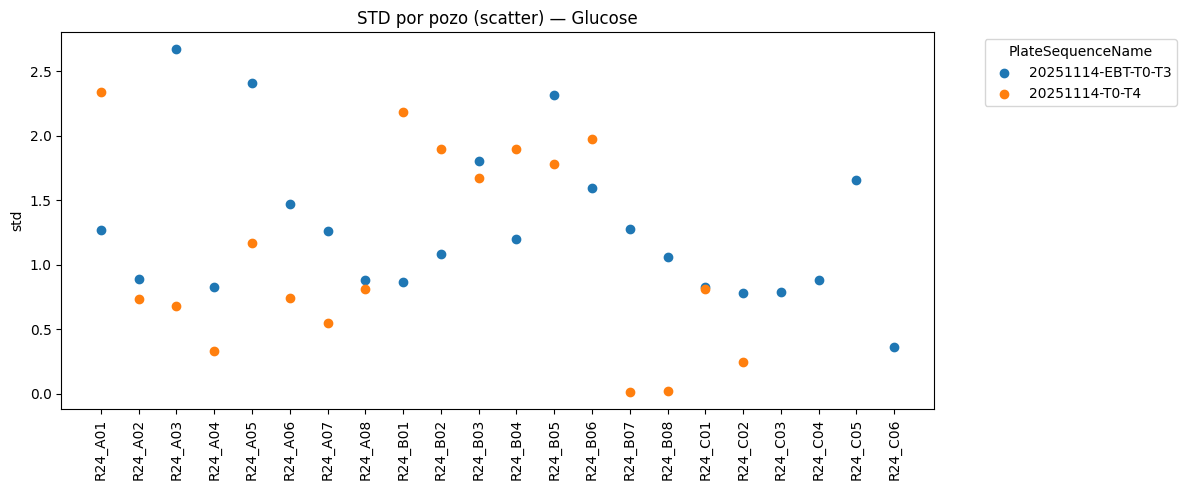

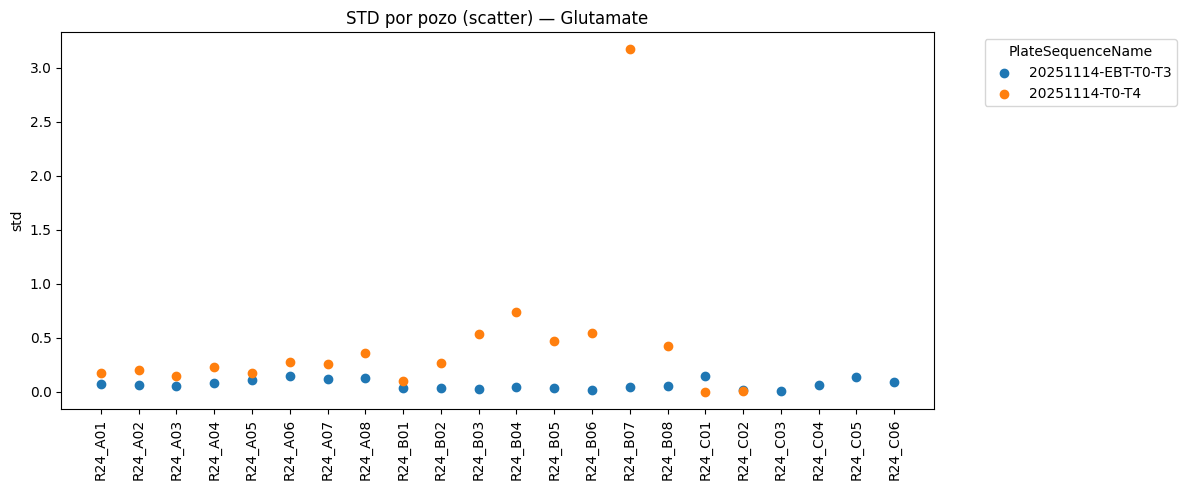

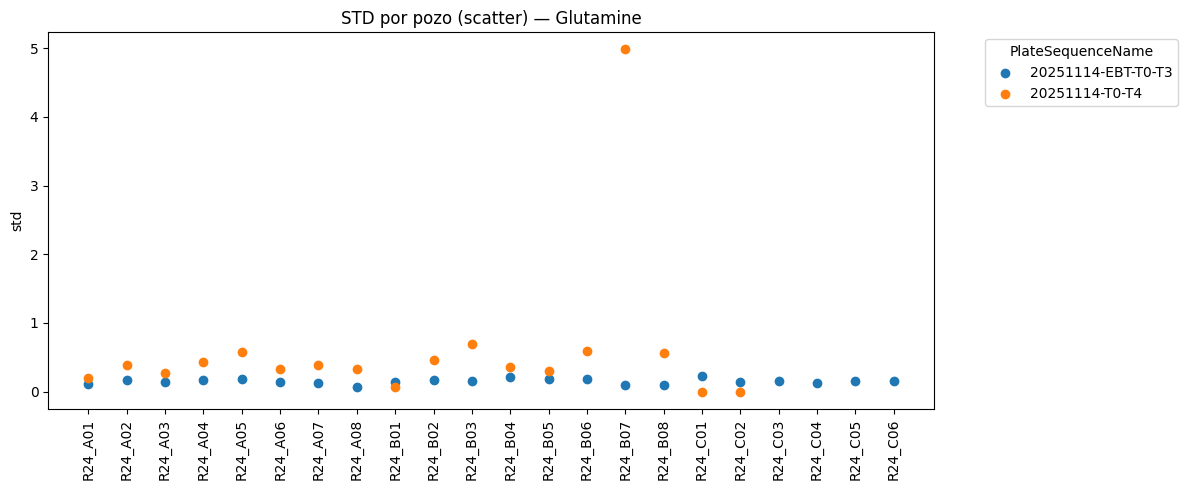

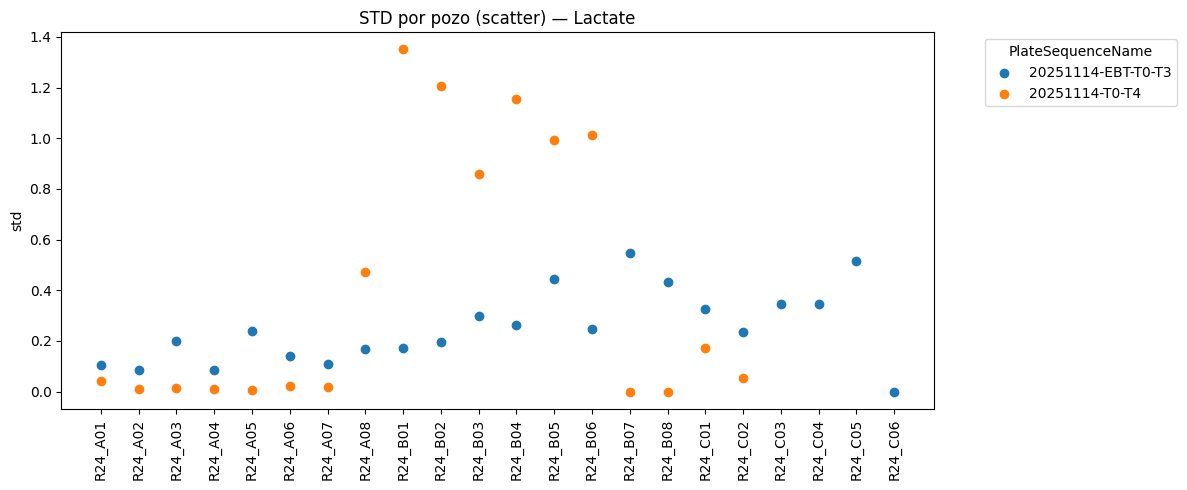

In [15]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

# Load summary file (from previous step)
summary = pd.read_csv("ysi_summary.csv")

# Pivot: rows = wells, columns = (PlateSequenceName, ChemistryId)
pivot_std = summary.pivot_table(
    index="WellId",
    columns=["PlateSequenceName", "ChemistryId"],
    values="std_value"
)

# Unique plate batches & metabolites
batches = summary["PlateSequenceName"].unique()
metabolitos = summary["ChemistryId"].unique()

# Plot scatter-style
import matplotlib.cm as cm
colors = cm.tab10(range(len(batches)))

for metabolito in metabolitos:
    plt.figure(figsize=(12, 5))

    for i, batch in enumerate(batches):
        col = (batch, metabolito)
        if col not in pivot_std.columns:
            continue

        plt.scatter(
            pivot_std.index,
            pivot_std[col],
            label=str(batch),
            color=colors[i]
        )

    plt.title(f"STD por pozo (scatter) — {metabolito}")
    plt.xticks(rotation=90)
    plt.ylabel("std")
    plt.legend(title="PlateSequenceName", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
